<a href="https://colab.research.google.com/github/Uzmamushtaque/Projects-in-Machine-Learning-and-AI/blob/main/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import drive

# drive.mount('/content/gdrive')

In [ ]:
# ROOT_DIR = "gdrive/MyDrive/DataStunt/CNN/"
ROOT_DIR = "../Input/"

In [ ]:
!pip install numpy==1.21.5
!pip install opencv_python_headless==4.4.0.46
!pip install torch==1.10.2
!pip install matplotlib==3.3.4
!pip install pandas==1.3.5
!pip install torchvision==0.11.3

In [ ]:
#Importing Necessary files to read Images
import pandas as pd
import numpy as np
import os
import cv2
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


In [ ]:
## Printing random images from the dataset

Training_folder=ROOT_DIR+"Data/Training_data"
os.listdir(Training_folder)


['driving_license', 'others', 'social_security']

In [ ]:
from torchvision.datasets import ImageFolder
ImageFolder(Training_folder)

Dataset ImageFolder
    Number of datapoints: 600
    Root location: ../Input/Data/Training_data

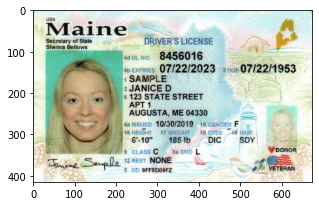

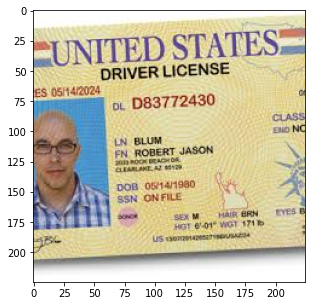

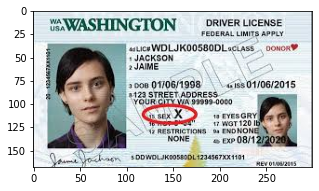

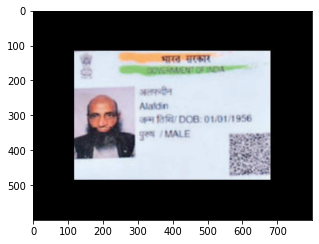

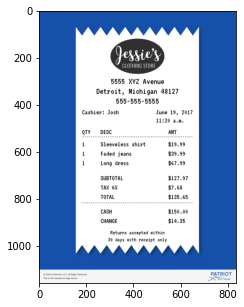

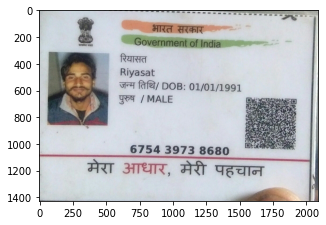

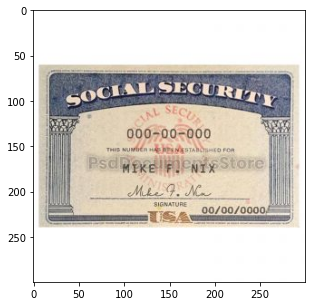

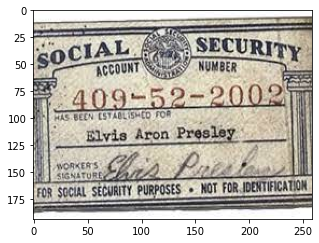

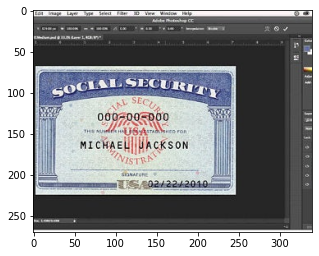

In [ ]:

for path in os.listdir(Training_folder):
    for i in range(3):
        temp_path = Training_folder+"/"+path
        file = random.choice(os.listdir(temp_path))
        image_path= os.path.join(temp_path, file)
        img=mpimg.imread(image_path)
        plt.figure(figsize=(5,5))
        plt.imshow(img)


In [ ]:
#Setting the Image dimension and source folder for loading the dataset
IMG_WIDTH=200
IMG_HEIGHT=200
Train_folder=ROOT_DIR+'Data/Training_data'
Test_folder=ROOT_DIR+'Data/Testing_Data'

In [ ]:
#Creating the image data and the labels from the images
def create_dataset(Train_folder):
    img_data_array=[]
    class_name=[]
    classes = {'driving_license': [1,0,0], 'others': [0,1,0], 'social_security': [0,0,1]}
    for PATH in os.listdir(Train_folder):
        for file in os.listdir(os.path.join(Train_folder, PATH)):
            image_path= os.path.join(Train_folder, PATH,  file)
            image= cv2.imread(image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float64')
            # image /= 255
            if len(image.shape) == 3:
                img_data_array.append(np.array(image).reshape([3, 200, 200]))
                class_name.append(classes[PATH])
    return img_data_array, class_name

In [ ]:
# extract the image array and class name for training data
Train_img_data, train_class_name = create_dataset(Train_folder)

# extract the image array and class name for testing data
Test_img_data, test_class_name =create_dataset(Test_folder)
len(Train_img_data)

597

In [ ]:
train_class_name[0]

[1, 0, 0]

In [ ]:
# Implementing a CNN in PyTorch
# importing necessary libraries
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim
import torch.utils.data as Data
from torch import Tensor
from torch.autograd import Variable

In [ ]:
# version of pytorch
print(torch.__version__)

1.10.2+cpu


In [ ]:
torch_dataset_train = Data.TensorDataset(Tensor(np.array(Train_img_data)), Tensor(np.array(train_class_name)))
torch_dataset_test = Data.TensorDataset(Tensor(np.array(Test_img_data)), Tensor(np.array(test_class_name)))

In [ ]:
# defining trainloader and testloader
trainloader = torch.utils.data.DataLoader(torch_dataset_train, batch_size=8, shuffle=True)
testloader = torch.utils.data.DataLoader(torch_dataset_test, batch_size=8, shuffle=True)

In [ ]:
# shape of training data
dataiter = iter(trainloader)
images = next(dataiter)
images[0].shape

torch.Size([8, 3, 200, 200])

In [ ]:
# defining the model architecture
class CNNNet(nn.Module):
  def __init__(self):
      super(CNNNet, self).__init__()

      self.cnn_layers = nn.Sequential(
          # Defining a 2D convolution layer
          nn.Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),
          nn.Conv2d(16, 3, kernel_size=(50, 50), stride=(1, 1)),
          nn.MaxPool2d(kernel_size=1, stride=1, padding=0, ceil_mode=False)
      )

      self.linear_layers = nn.Sequential(
          nn.Linear(3, 3)
      )

  # Defining the forward pass
  def forward(self, x):
      x = self.cnn_layers(x)
      x = x.view(x.size(0), -1)
      x = self.linear_layers(x)
      return x


#define the optimizer and loss function
# defining the model
model = CNNNet()
# defining the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.0001)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
print(torch.cuda.is_available())
if torch.cuda.is_available():
    model = model.to("cuda")
    criterion = criterion.to("cuda")

print(model)


False
CNNNet(
  (cnn_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 3, kernel_size=(50, 50), stride=(1, 1))
    (4): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=3, out_features=3, bias=True)
  )
)


In [ ]:
!export CUDA_LAUNCH_BLOCKING=1

'export' is not recognized as an internal or external command,
operable program or batch file.


In [ ]:
#train this model for 10 epochs
for i in range(10):

    running_loss = 0
    model.train() # indicator for training phase
    for images, labels in trainloader:

        if torch.cuda.is_available():
          images = images.to("cuda")
          labels = labels.to("cuda")

        # Training pass
        optimizer.zero_grad()

        output = model(images)

        loss = criterion(output, labels)

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()

        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(trainloader)))

Epoch 1 - Training loss: 14.138532303969065
Epoch 2 - Training loss: 0.5852703469991684
Epoch 3 - Training loss: 0.3740518253048261
Epoch 4 - Training loss: 0.2375350059568882
Epoch 5 - Training loss: 0.17135330153008302
Epoch 6 - Training loss: 0.11833347778767347
Epoch 7 - Training loss: 0.08159022180984418
Epoch 8 - Training loss: 0.06119999563631912
Epoch 9 - Training loss: 0.047726723592107494
Epoch 10 - Training loss: 0.0358329328118513


In [ ]:
filepath ='../output/'+"model.pt"
torch.save(model.state_dict(), filepath)

In [ ]:
# model_trained = CNNNet()
# model_trained.load_state_dict(torch.load(filepath))

In [ ]:
# device = "cuda"--> use if you have GPU

In [ ]:
# [.2, .5, .3]
# y_pred_list = []
# y_true_list = []
# with torch.no_grad():
#     for x_batch, y_batch in testloader:
#         x_batch, y_batch = x_batch.to(device), y_batch.to(device)
#         y_test_pred = model(x_batch)
#         print(y_test_pred)
#         _, y_pred_tag = torch.max(y_test_pred, dim = 1)
#         y_pred_list.extend(y_pred_tag.cpu().numpy())
#         y_true_list.extend(y_batch.cpu().numpy())

#prediction
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in testloader:
        x_batch, y_batch = x_batch.to(), y_batch.to()
        y_test_pred = model(x_batch)
        print(y_test_pred)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.extend(y_pred_tag.cpu().numpy())
        y_true_list.extend(y_batch.cpu().numpy())

tensor([[ -2.8654,   4.5774,   5.5074],
        [ 10.3186,  -9.6699,  -1.5202],
        [ 16.9135, -15.7942,   2.1405],
        [ -3.6676,   4.0255,   0.0741],
        [  6.9533,  -2.4064,  18.5245],
        [ -0.1860,   1.3053,   4.0689],
        [ 15.5688, -16.6959,  -9.1527],
        [ -0.5128,   2.2798,   5.5503]])
tensor([[  8.3049,  -7.5075,   0.5044],
        [ 13.5754, -14.2360,  -6.9449],
        [ -3.9952,   4.2582,  -0.5775],
        [ -4.3977,   5.1900,   1.9036],
        [  6.8648,  -3.4713,  13.3747],
        [  2.2268,   0.6390,  13.6918],
        [  4.7977,  -5.1595,  -3.4305],
        [ -4.5472,   5.0221,   0.3816]])
tensor([[-4.3741,  5.0640,  1.5280],
        [-1.5588,  3.6088,  7.5262],
        [-0.8957,  2.2674,  4.1694],
        [ 1.5824,  1.4139, 10.5292],
        [-5.1772,  5.6864,  0.7436],
        [-5.0517,  4.7642, -2.6445],
        [ 0.0640,  1.4306,  5.3235],
        [-4.1754,  4.7075,  0.9330]])
tensor([[  4.0625,  -3.4866,   0.1365],
        [ -1.9352,   

In [ ]:
#y_test
y_true_list_max = [m.argmax() for m in y_true_list]

In [ ]:
#Accuracy of model
correct_count, all_count = 0, 0
for i in range(len(y_pred_list)):
    if(y_pred_list[i] == y_true_list_max[i]):
      correct_count += 1
    all_count += 1
print("\nModel Accuracy =", (correct_count/all_count))


Model Accuracy = 0.912751677852349
